In [33]:
from openai import OpenAI

import os
import io
import base64
from dotenv import load_dotenv
from IPython.display import display, Markdown
from PIL import Image
import json

In [2]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

In [12]:
openai = OpenAI(api_key = openai_api_key)

In [4]:
def print_markdown(text):
    """Better output format for notebooks"""
    display(Markdown(text))

In [24]:
image_filename = "../../images/food_image.jpg"

img = Image.open(image_filename)
print(f"Image '{image_filename} loaded successfully")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

Image '../../images/food_image.jpg loaded successfully
Format: JPEG
Size: (600, 400)
Mode: RGB


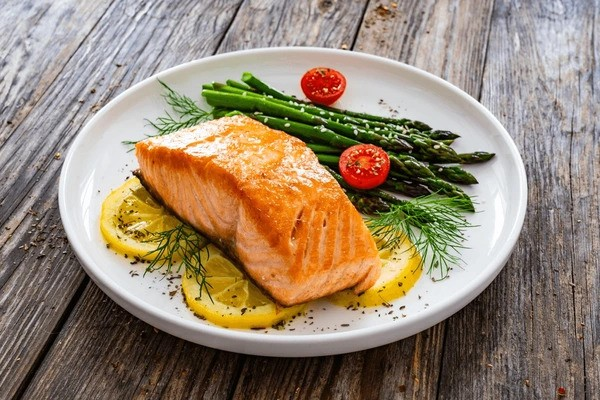

In [25]:
display(img)

In [26]:
# Save in a variable for later use
img_to_analyze = img

In [27]:
def encode_image_to_base64(image_path_or_pil):
    """
    Function that converts an image into base64 text
    It can take two different types of inputs:

    1) A file path in string format
    2) An image object that is already loaded in memory as a PIL object
    """
    if isinstance(image_path_or_pil, str):
        # Check to see if file exists
        if not os.path.exists(image_path_or_pil):
            raise FileNotFoundError(f"Image file not found at {image_path_or_pil}")
        with open(image_path_or_pil, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    elif isinstance(image_path_or_pil, Image.Image): # if it's a PIL Image object
        buffer = io.BytesIO()
        image_format = image_path_or_pil.format or "JPEG" # Default to JOEG if format is unkown
        image_path_or_pil.save(buffer, format=image_format)
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError("Input must be a file path (str) or a PIL Image object")

In [28]:
def query_openai_vision(client, image, prompt, model = "gpt-4o", max_tokens=100):
    """
    Function that will query OpenAI's Vision Model with an image.

    Args:
        client: The OpenAI client
        image: PIL image object to analyze
        prompt: Text prompt to send with the image with context / instructions
        model: OpenAI model to use (default: gpt-4o)
        max_tokens: Maximum number of tokens in the respose (default: 100)

    Returns:
        The models response text or an error message 
    """

    # Encode image to base64
    base64_image = encode_image_to_base64(image)

    try:
        # Construct message payload
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            }
        ]

        # Make the API call
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=max_tokens,
        )

        # Retrieve the response
        return response.choices[0].message.content

    except Exception as e:
        return f"Error calling API: {e}"


In [29]:
# Prompt to pass into the 'query_vision_api' function along with the image
food_identification_prompt = """
Context: I am analyzing food for a calorie-tracking application. 
Instruction: Please identify the food items in this image.
Input: [The image I am sharing]
Output: Provide the name of the food(s), a brief description of what you see, and if possible, list the typical ingredients or nutritional profile
"""

print(f"{food_identification_prompt}")


Context: I am analyzing food for a calorie-tracking application. 
Instruction: Please identify the food items in this image.
Input: [The image I am sharing]
Output: Provide the name of the food(s), a brief description of what you see, and if possible, list the typical ingredients or nutritional profile



In [30]:
# Call the 'query_vision_api' function and pass in the prompt and image
print(f"Initiated OpenAI Vision call...")
openai_description = query_openai_vision(
    openai,
    img_to_analyze,
    food_identification_prompt
)
print_markdown(openai_description)

Initiated OpenAI Vision call...


**Food Items:**

1. **Grilled Salmon**
   - **Description:** A piece of grilled salmon placed on a bed of lemon slices with some dill.
   - **Nutritional Profile:** High in protein and omega-3 fatty acids, and contains vitamins like D and B12. Calorically dense due to healthy fats.

2. **Asparagus**
   - **Description:** Several stalks of asparagus seasoned and placed alongside the salmon.
   - **Nutritional Profile:**

In [31]:
# Structured prompt
structured_nutrition_prompt = """
# Nutritional Analyst Task

## Context
You are a nutrition expert analyzing food images to provide accurate nutritional information.

## Instructions
Analyze the food items in the image and provide estimated nutritional information based on your knowledge.

## Input
- An image of food items

## Output
Provide the following estimated nutritional information for a typical serving size or per 100g:
- food_name (string)
- serving_description (string, e.g., '1 slice', '100g', '1 cup')
- calories (float)
- fat_grams (float)
- protein_grams (float)
- confidence_level (string: 'High', 'Medium' )

**IPORTANT:** Respond only with a single JSON object containing these fields, do not include any other text, explanations, or apologies.

Example valid JSON response:
{
    "food_name": "Banana",
    "serving_description": "1 medium banana (approx 118g)",
    "calories": 105.0,
    "fat_grams": 0.4,
    "protein_grams": 1.3,
    "confidence_level": "High"
}
"""

In [37]:
# Updated API request with the more structured prompt
openai_nutrition_result = query_openai_vision(
    client = openai,
    image = img_to_analyze,
    prompt = structured_nutrition_prompt,
)
print_markdown(openai_nutrition_result)

```json
{
    "food_name": "Grilled Salmon with Asparagus and Tomatoes",
    "serving_description": "1 plate (approx 250g total)",
    "calories": 400.0,
    "fat_grams": 20.0,
    "protein_grams": 35.0,
    "confidence_level": "High"
}
```